
### Neural-Network optimizers:🧠
- Gradient Descent
- Stochastic Gradient Descent (SGD)
- Mini Batch Stochastic Gradient Descent (MBSGD)
- SGD with momentum
- Nesterov Accelerated Gradient (NAG)
- Adaptive Gradient
- AdaDelta
- RMSprop
- Adam 

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm import tqdm_notebook
import seaborn as sns
import imageio
import time 
from IPython.display import HTML

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

### Generate Data

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


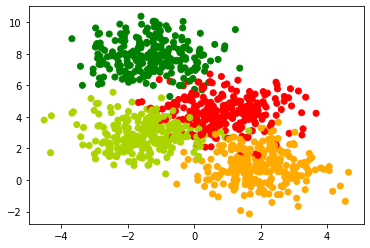

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap = my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

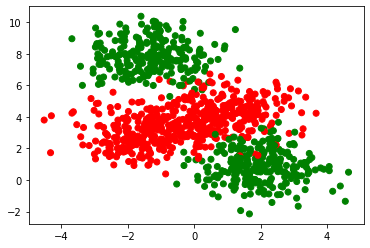

In [7]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap = my_cmap)
plt.show()

### Multi class classification

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [9]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [10]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


### FF Class

In [11]:
class FFNetwork:
    
    def __init__(self, W1, W2):
        
        self.params={}
        self.params["W1"]=W1.copy()
        self.params["W2"]=W2.copy()
        self.params["B1"]=np.zeros((1,2))
        self.params["B2"]=np.zeros((1,4))
        self.num_layers=2
        self.gradients={}
        self.update_params={}
        self.prev_update_params={}
        for i in range(1, self.num_layers+1):
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0
    
    def forward_activation(self, X):
        return 1.0/(1.0 + np.exp(-X))
    
    def grad_activation(self, X):
        return X*(1-X)
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis=1).reshape(-1,1)
    
    def forward_pass(self, X, params = None):
        if params is None:
            params = self.params
        self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
        self.H1 = self.forward_activation(self.A1) #(N, 2)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
        self.H2 = self.softmax(self.A2) # (N, 4)
        return self.H2
    
    def grad(self, X, Y, params = None):
        if params is None:
            params = self.params
        
        self.forward_pass(X, params)
        m = X.shape[0]
        self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

    def fit(self, X, Y, epochs=1, algo="GD", display_loss=False, eta=1, mini_batch_size=100, eps=1e-8,beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9):
        
        if display_loss:
            loss={}
            for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
                m = X.shape[0]
                
                if algo == "GD":
                    self.grad(X,Y)
                    for i in range (1, self.num_layers+1):
                        self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
                        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
                
                elif algo == "MiniBatch":
                    for k in range(0, m, mini_batch_size):
                        self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                        for i in range(1, self.num_layers+1):
                            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
                            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
                        
                    
                elif algo == "Momentum":
                    self.grad(X,Y)
                    for i in range(1, self.num_layers+1):
                        self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                        self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                        self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                        self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
                        
                elif algo == "NAG":
                    temp_params = {}
                    for i in range(1, self.num_layers+1):
                        self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
                        self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]
                        temp_params["W"+str(i)] = self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
                        temp_params["B"+str(i)] = self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
                    self.grad(X, Y, temp_params)
                    for i in range(1, self.num_layers+1):
                        self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                        self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                        self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                        self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)])
                    self.prev_update_params = self.update_params
                
                elif algo == "AdaGrad":
                    self.grad(X, Y)
                    for i in range(1, self.num_layers+1):
                        self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
                        self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
                        self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
                        self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
                    
            
                elif algo == "RMSProp":
                    self.grad(X, Y)
                    for i in range(1, self.num_layers+1):
                        self.update_params["v_w"+str(i)] = beta * self.update_params["v_w"+str(i)] + (1-beta) * ((self.gradients["dW"+str(i)]/m)**2)
                        self.update_params["v_b"+str(i)] = beta * self.update_params["v_b"+str(i)] + (1-beta) * ((self.gradients["dB"+str(i)]/m)**2)
                        self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
                        self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
                
                elif algo == "Adam":
                    self.grad(X, Y)
                    num_updates=0
                    for i in range(1, self.num_layers+1):
                        num_updates+=1
                        self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
                        self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
                        m_w_hat = self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                        v_w_hat = self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                        self.params["W"+str(i)] -= (eta/np.sqrt(v_w_hat+eps))*m_w_hat
                        
                        self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
                        self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
                        m_b_hat = self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                        v_b_hat = self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
                        self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
                    
                if display_loss:
                    Y_pred = self.predict(X)
                    loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
            
            if display_loss:
                plt.plot(np.fromiter(loss.values(), dtype = float), '-o',markersize=5)
                plt.xlabel('Epochs')
                plt.ylabel('Log Loss')
                plt.show()
            
    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()

In [12]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


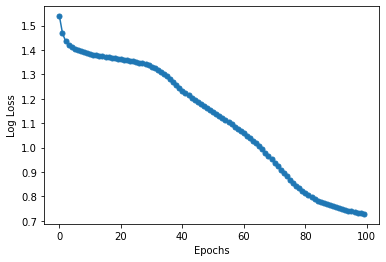

Training accuracy 0.7053
Validation accuracy 0.716
CPU times: user 305 ms, sys: 10.9 ms, total: 316 ms
Wall time: 317 ms


In [13]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


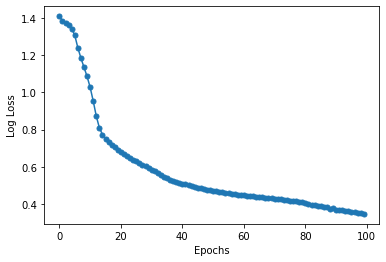

Training accuracy 0.8867
Validation accuracy 0.904
CPU times: user 366 ms, sys: 9.41 ms, total: 375 ms
Wall time: 365 ms


In [14]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


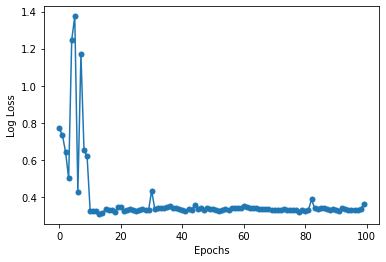

Training accuracy 0.8587
Validation accuracy 0.856
CPU times: user 1.41 s, sys: 6.53 ms, total: 1.42 s
Wall time: 1.41 s


In [15]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


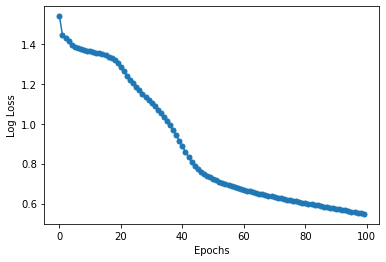

Training accuracy 0.8387
Validation accuracy 0.852
CPU times: user 289 ms, sys: 8.05 ms, total: 297 ms
Wall time: 294 ms


In [16]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


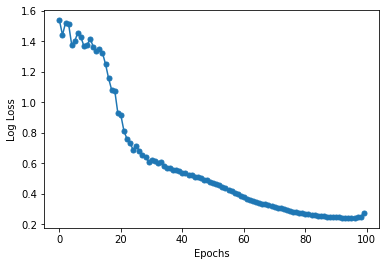

Training accuracy 0.8947
Validation accuracy 0.916
CPU times: user 325 ms, sys: 3.72 ms, total: 328 ms
Wall time: 327 ms


In [17]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


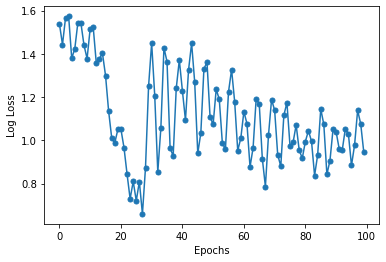

Training accuracy 0.6347
Validation accuracy 0.66
CPU times: user 326 ms, sys: 12.1 ms, total: 338 ms
Wall time: 330 ms


In [18]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


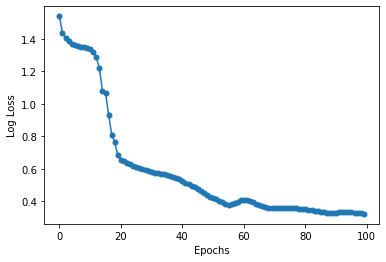

Training accuracy 0.88
Validation accuracy 0.872
CPU times: user 315 ms, sys: 10.3 ms, total: 325 ms
Wall time: 320 ms


In [19]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


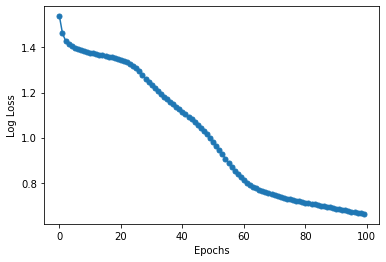

Training accuracy 0.704
Validation accuracy 0.728
CPU times: user 292 ms, sys: 4.95 ms, total: 297 ms
Wall time: 293 ms


In [20]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


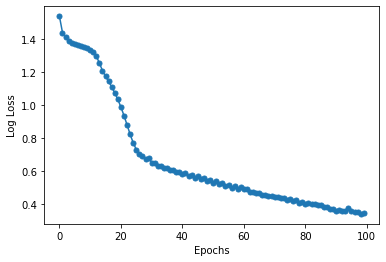

Training accuracy 0.8773
Validation accuracy 0.9
CPU times: user 291 ms, sys: 4.96 ms, total: 296 ms
Wall time: 294 ms


In [21]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


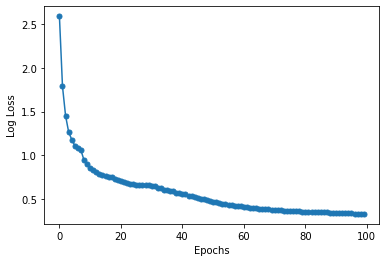

Training accuracy 0.88
Validation accuracy 0.904
CPU times: user 308 ms, sys: 15 ms, total: 323 ms
Wall time: 315 ms


In [22]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


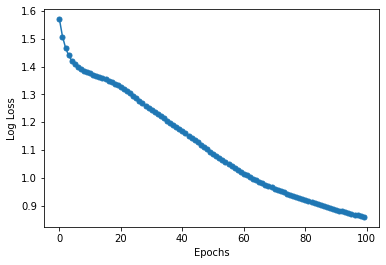

Training accuracy 0.644
Validation accuracy 0.636
CPU times: user 305 ms, sys: 3.78 ms, total: 309 ms
Wall time: 307 ms


In [23]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


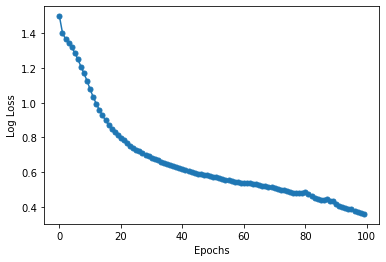

Training accuracy 0.8827
Validation accuracy 0.908
CPU times: user 312 ms, sys: 7 ms, total: 319 ms
Wall time: 316 ms


In [24]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


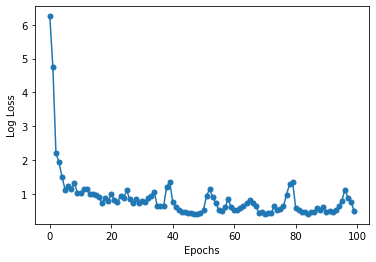

Training accuracy 0.8453
Validation accuracy 0.844
CPU times: user 304 ms, sys: 8.43 ms, total: 312 ms
Wall time: 306 ms


In [25]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


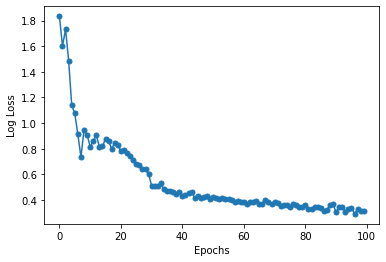

Training accuracy 0.8973
Validation accuracy 0.884
CPU times: user 333 ms, sys: 7.22 ms, total: 341 ms
Wall time: 335 ms


In [26]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


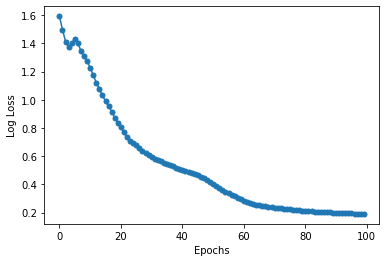

Training accuracy 0.9227
Validation accuracy 0.94
CPU times: user 318 ms, sys: 8.91 ms, total: 326 ms
Wall time: 323 ms


In [27]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

### Good configurations with each algo

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


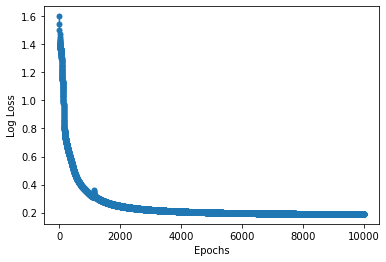

Training accuracy 0.9293
Validation accuracy 0.936
CPU times: user 14.9 s, sys: 81.5 ms, total: 15 s
Wall time: 14.9 s


In [28]:

%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


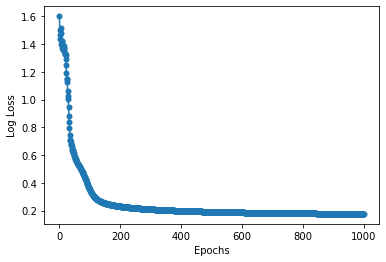

Training accuracy 0.9267
Validation accuracy 0.944
CPU times: user 1.72 s, sys: 15 ms, total: 1.73 s
Wall time: 1.72 s


In [29]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


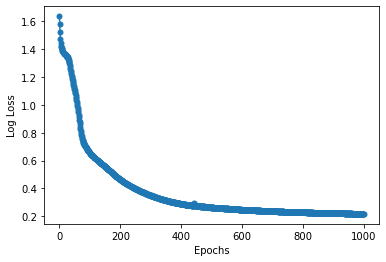

Training accuracy 0.912
Validation accuracy 0.936
CPU times: user 1.78 s, sys: 19.9 ms, total: 1.8 s
Wall time: 1.79 s


In [30]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


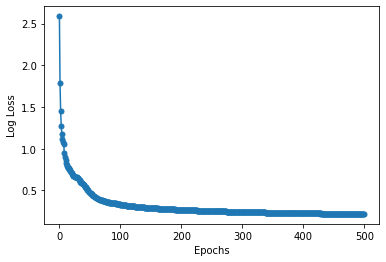

Training accuracy 0.912
Validation accuracy 0.936
CPU times: user 921 ms, sys: 11.1 ms, total: 932 ms
Wall time: 925 ms


In [31]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


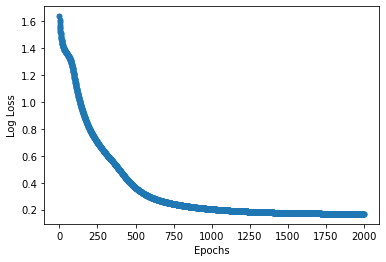

Training accuracy 0.924
Validation accuracy 0.94
CPU times: user 3.26 s, sys: 29 ms, total: 3.29 s
Wall time: 3.27 s


In [32]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


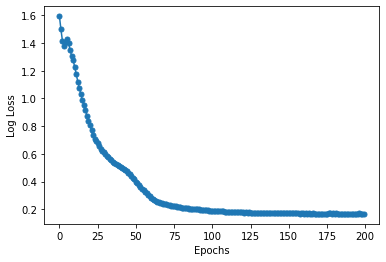

Training accuracy 0.9293
Validation accuracy 0.952
CPU times: user 484 ms, sys: 5.05 ms, total: 489 ms
Wall time: 484 ms


In [33]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()